In [1]:
#Install dependencies 
%matplotlib inline
import cv2
import dlisio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import arange
from scipy.optimize import curve_fit
from dlisio import dlis
from collections import Counter
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

##IF USING TF 2 use following import to still use TF < 2.0 Functionalities
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

import numpy as np
from tqdm import tqdm

In [210]:
filepath = "/home/dkdms/cced_scripts/CCED-internal/path_open_iterative_small.PNG"

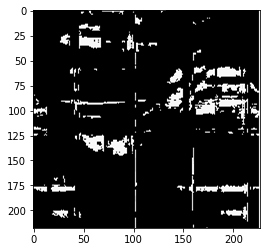

In [215]:
image_array = cv2.imread(filepath)
gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap = "gray")

In [216]:
gray_image.shape

(218, 227)

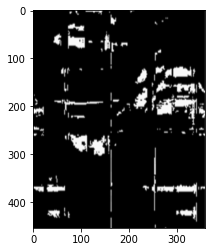

In [217]:
image_array = cv2.resize(gray_image, (360,image_array.shape[1]*2))
plt.imshow(image_array,cmap = "gray")

In [218]:
def conventional_method(data,threshold):
    img = data.astype(np.uint8)
#     equ = cv2.equalizeHist(img)
    kernel_cv = np.ones((5,5), np.uint8)
    img_erosion = cv2.erode(img, kernel_cv, iterations=1)
    img_dilation = cv2.dilate(img_erosion, kernel_cv, iterations=1)    
    opening = cv2.morphologyEx(img_dilation, cv2.MORPH_OPEN, kernel_cv)
    ret, thresh1 = cv2.threshold(img_dilation, threshold, 255, cv2.THRESH_BINARY)  
#     bw =  255 -opening
    bw = np.abs(255-thresh1)
    return img_erosion,img_dilation,opening, bw

In [219]:
def edge_detect(bw):
    # canny edge detection  & houghs transformation
    img = bw.astype(np.uint8)
    img = cv2.medianBlur(img, 5)
    edges = cv2.Canny(img, 150, 255, apertureSize=7)
    minLineLength = 30
    maxLineGap = 5
    lines = cv2.HoughLinesP(edges, cv2.HOUGH_PROBABILISTIC, np.pi/180, 30, minLineLength, maxLineGap)
    x_data = []
    y_data = []

    #fig = images[1]
    if lines is not None and len(lines) !=0:
      for x in range(0, len(lines)):
          for x1,y1,x2,y2 in lines[x]:
            x_data.append(x1)
            y_data.append(y1)      
            x_data.append(x2)
            y_data.append(y2)
            pts = np.array([[x1, y1 ], [x2, y2]], np.int32)
      return x_data,y_data
    else:
      return (0,0)
    

In [220]:
def curve_fitting(x_data,y_data):
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)
    x, y = x_data, y_data
    guess_amp = np.std(y) * 2.**0.5
    guess_offset = np.mean(y)
    guess = np.array([7,-3, guess_offset])

    def sinfunc(t, A, p, c):  return A * np.sin(0.0175*t + p) + c
    # curve fit
    popt, pcov = curve_fit(sinfunc, x, y, p0=guess)
    A, p, c = popt
    w=0.0175
    f = w/(2.*np.pi)
    fitfunc = lambda t:  A*np.sin(w*t + p) + c
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(0, 360,1) 
    # calculate the output for the range
    y_line = fitfunc(x_line)
    # create a line plot for the mapping function
#     plt.plot(x_line, y_line, color='blue')
    #plt.show()
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov),"x_line":x_line,"y_line":y_line}

In [221]:
def plot(x_line,y_line,data,tdep,cmap):
    plt.plot(x_line,y_line)
    plt.imshow(data, cmap=cmap)
    plt.yticks(np.linspace(0, data.shape[0],5), np.linspace(tdep[0], tdep[-1], 5).round(2))   
    plt.xticks(np.arange(0,361,30))
    plt.show()

In [222]:
# dip (in Radians) = tan_inv (A / Rwell), and Rwell is the well radius
# Az (in Radians) = pi/2 - B
def calculatDipAzimuth(amp,phase,rwell):
    amp = amp * 0.0013302752
    dip = np.arctan(amp/rwell)
    dip_deg = dip*(180/(np.pi))
    phase = phase
    azimuth =  np.pi/2 - phase
    azimuth_deg = azimuth*(180/(np.pi))
    return dip_deg, azimuth_deg   

In [309]:
img_erosion,img_dilation,opening,bw = conventional_method(image_array,155)
x_data,y_data = edge_detect(bw)
x_data = np.array(x_data)
y_data = np.array(y_data)    

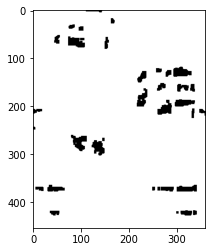

In [310]:
# plt.figure(figsize=(8, 8))
plt.imshow(bw, cmap = "gray")  
plt.show()

In [311]:
bw.shape

(454, 360)

In [312]:
len(x_data)

30

# Clustering the points

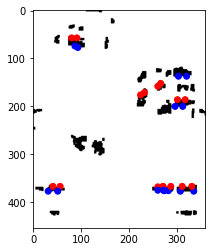

In [313]:
# plt.figure(figsize=(30, 30))
y_pred =[]
color= []
X = np.stack((x_data,y_data),axis=1)
for i in X:
    if i[1]<(image_array.shape[0]-1) and i[1]>0 and bw[i[1]-1][i[0]]==0 and bw[i[1]+1][i[0]]==255:
        y_pred.append(0)
        color.append("blue")
    else:
        y_pred.append(1)
        color.append("red")

plt.scatter(X[:, 0], X[:, 1], c=color)
plt.imshow(bw,cmap = "gray")
# plt.yticks(np.linspace(0, depth_1_imputed.shape[0],20), np.linspace(tdep_array[0], tdep_array[-1], 20).round(2)) 
# plt.xticks(np.linspace(0,360,3))
plt.show()

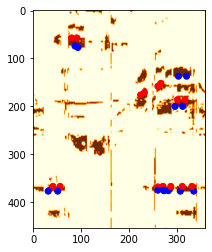

In [314]:
# plt.figure(figsize=(30, 30))
plt.scatter(X[:, 0], X[:, 1], c=color)
plt.imshow(image_array,cmap = "YlOrBr")
# plt.yticks(np.linspace(0, depth_1_imputed.shape[0],20), np.linspace(tdep_array[0], tdep_array[-1], 20).round(2)) 
# plt.xticks(np.linspace(0,360,3))
plt.show()

# Curve fitting

In [315]:
x_curve ={}
y_curve = {}
dip = []
azimuth = []
offset = []

In [316]:
y_pred = np.asarray(y_pred)
x_data_cluster_0 = x_data[np.where(y_pred == 0)]
y_data_cluster_0 = y_data[np.where(y_pred ==0)]
x_data_cluster_1 = x_data[np.where(y_pred == 1)]
y_data_cluster_1 = y_data[np.where(y_pred ==1)]

In [317]:
X_cluster_0 = np.stack((x_data_cluster_0,y_data_cluster_0),axis=1)
X_cluster_0 = X_cluster_0[X_cluster_0[:, 1].argsort()]
flag = 0
curve_data_x = []
curve_data_y = []
index = 0
for x,y in X_cluster_0:
    if flag == 0:
        start_y = y
        flag=1
    if y-start_y<80:
        curve_data_x.append(x)
        curve_data_y.append(y)
    else:
        if len(curve_data_x)>=5:
            res = curve_fitting(curve_data_x, curve_data_y)
            x_curve[index] = res["x_line"]
            y_curve[index] = res["y_line"]
            dip_deg, azimuth_deg = calculatDipAzimuth(res["amp"],res["phase"],0.108)
            dip.append(dip_deg.round(2))
            azimuth.append(azimuth_deg.round(2))
#             offset.append((tdep_array[int(np.floor( y_curve[index][0]))]).round(2))
            index+=1
        curve_data_x = []
        curve_data_y = []
        flag =0

In [318]:
X_cluster_1 = np.stack((x_data_cluster_1,y_data_cluster_1),axis=1)
X_cluster_1 = X_cluster_1[X_cluster_1[:, 1].argsort()]
flag = 0
curve_data_x = []
curve_data_y = []
for x,y in X_cluster_1:
    if flag == 0:
        start_y = y
        flag=1
    if y-start_y<80:
        curve_data_x.append(x)
        curve_data_y.append(y)
    else:
        if len(curve_data_x)>=5:
            res = curve_fitting(curve_data_x, curve_data_y)
            x_curve[index] = res["x_line"]
            y_curve[index] = res["y_line"]
            dip_deg, azimuth_deg = calculatDipAzimuth(res["amp"],res["phase"],0.108)
            dip.append(dip_deg.round(2))
            azimuth.append(azimuth_deg.round(2))
#             offset.append((tdep_array[int(np.floor( y_curve[index][0]))]).round(2))

            index+=1
        curve_data_x = []
        curve_data_y = []
        flag =0
    
     
    

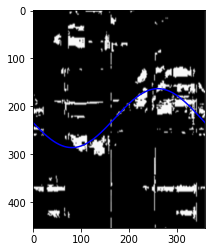

In [319]:
# plt.figure(figsize=(20, 20))
for index in range(len(y_curve)):
    plt.plot(x_curve[index],y_curve[index],color = "blue")
plt.imshow(image_array,cmap="gray")
# plt.yticks(np.linspace(0, depth_1_imputed.shape[0],100), np.linspace(tdep_array[0], tdep_array[-1], 100).round(2)) 
# plt.xticks(np.linspace(0,360,3))
plt.show()

In [320]:
print(dip)

[-37.17]


In [321]:
print(azimuth)

[260.81]
